In [1]:
from __future__ import print_function, division
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, transform

In [2]:
plt.rcParams['figure.figsize'] = [15,15]

## Understanding Images and Labels

In [3]:
train_labels = pd.read_json("det_train_shortened.json") # pandas df

In [4]:
def draw_bounding_box(im, labels):
    plt.imshow(im)

    for object in train_labels["labels"][0]:
        x_min = object["box2d"]["x1"]
        x_max = object["box2d"]["x2"]
        y_min = object["box2d"]["y1"]
        y_max = object["box2d"]["y2"]
        x_points = [x_min, x_min, x_max, x_max, x_min]
        y_points = [y_min, y_max, y_max, y_min, y_min]

        plt.plot(x_points, y_points, 'r-')

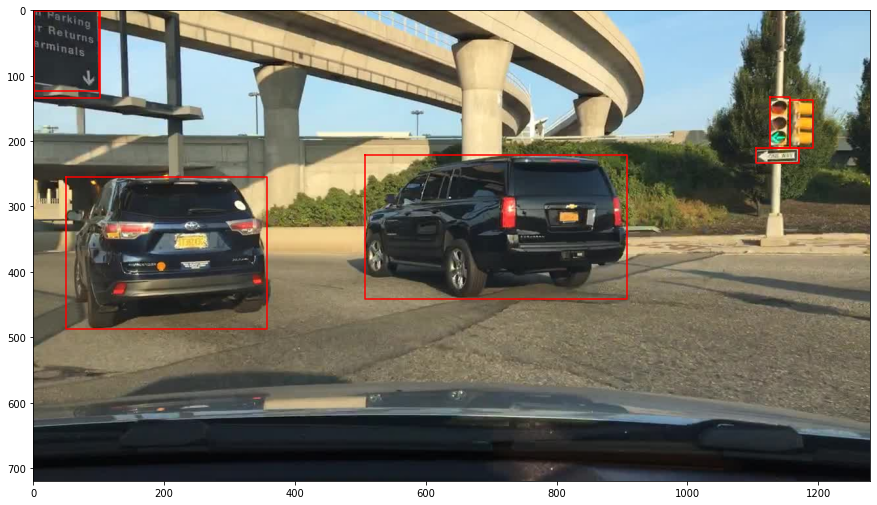

In [61]:
im = plt.imread("testing_image.jpg")
draw_bounding_box(im, train_labels)

## Parsing Useful Labels

In [ ]:
# current structure

# data_labels = {
#     'im_name' : [
#         {obj1},
#         {obj2},
#         ...
#     ]
# }

# pd dataframe doesnt seem viable - varying number of objects in each image

In [10]:
def filter_labels(raw_json):
    data_labels = {}
    for idx, label in enumerate(raw_json["labels"]):
        objects = []
        obj = {}

        for object in label:
            #obj["id"] = object["id"] # object id probs not useful?
            obj["category"] = object["category"]
            obj["box2d"] = object["box2d"]
            objects.append(obj)
            obj = {}

        data_labels[str(train_labels["name"][idx])] = objects
    
    return data_labels

In [11]:
labels_json = pd.read_json("det_train_shortened.json")
filtered_labels = filter_labels(labels_json)

## Load Images and Labels

In [ ]:
# for getitem
# {
#     img: image
#     category: [car, sign, ped]
#     box2d: [[x1, x2, y1, y2],
#             [x1, x2, y1, y2],
#             [x1, x2, y1, y2]]
# }

In [ ]:
# bbox_labels = [ [[c1], [c2], [c3]],
#                 [[c1], [c2], [c3]],
#                 ...
#             ]

In [74]:
class DetectionDataset(Dataset):
    def __init__(self, label_dict, root_dir, transform=None):
        self.labels = label_dict
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return(self.labels)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        ## collect all image names
        img_name = os.path.join(self.root_dir, list(self.labels.keys()))
        image = io.imread(img_name)
        
        ## collect all labels per image
        category_labels = []
        for image_idx in range(len(filtered_labels)):
            curr_im_cat_labels = [obj["category"] for obj in list(filtered_labels.values())[image_idx]]
            category_labels.append(curr_im_cat_labels)
        
        ## collect all bounding box coords per image
        bbox_labels = []
        for image in category_labels: # iterate through each image label set
            cur_image = []
            for bbox in image: # iterate through each set of coords in image label set
                coords = []
                for _, bbox_value in bbox.items(): # iterate through each indiv coord and pull out values
                    # fill list with coords [x1, y1, x2, y2]
                    coords.append(bbox_value)
                # add the [x1, y1, x2, y2] to current image list
                cur_image.append(coords)

            # add the current image list to full list of images
            bbox_labels.append(cur_image)

        sample = {"image": image, "categories": category_labels, "bboxes": bbox_labels}

        if self.transform:
            sample = self.transform(sample)

        return sample